Files already downloaded and verified
Files already downloaded and verified
测试集大小为： 10000
训练集大小为： 50000


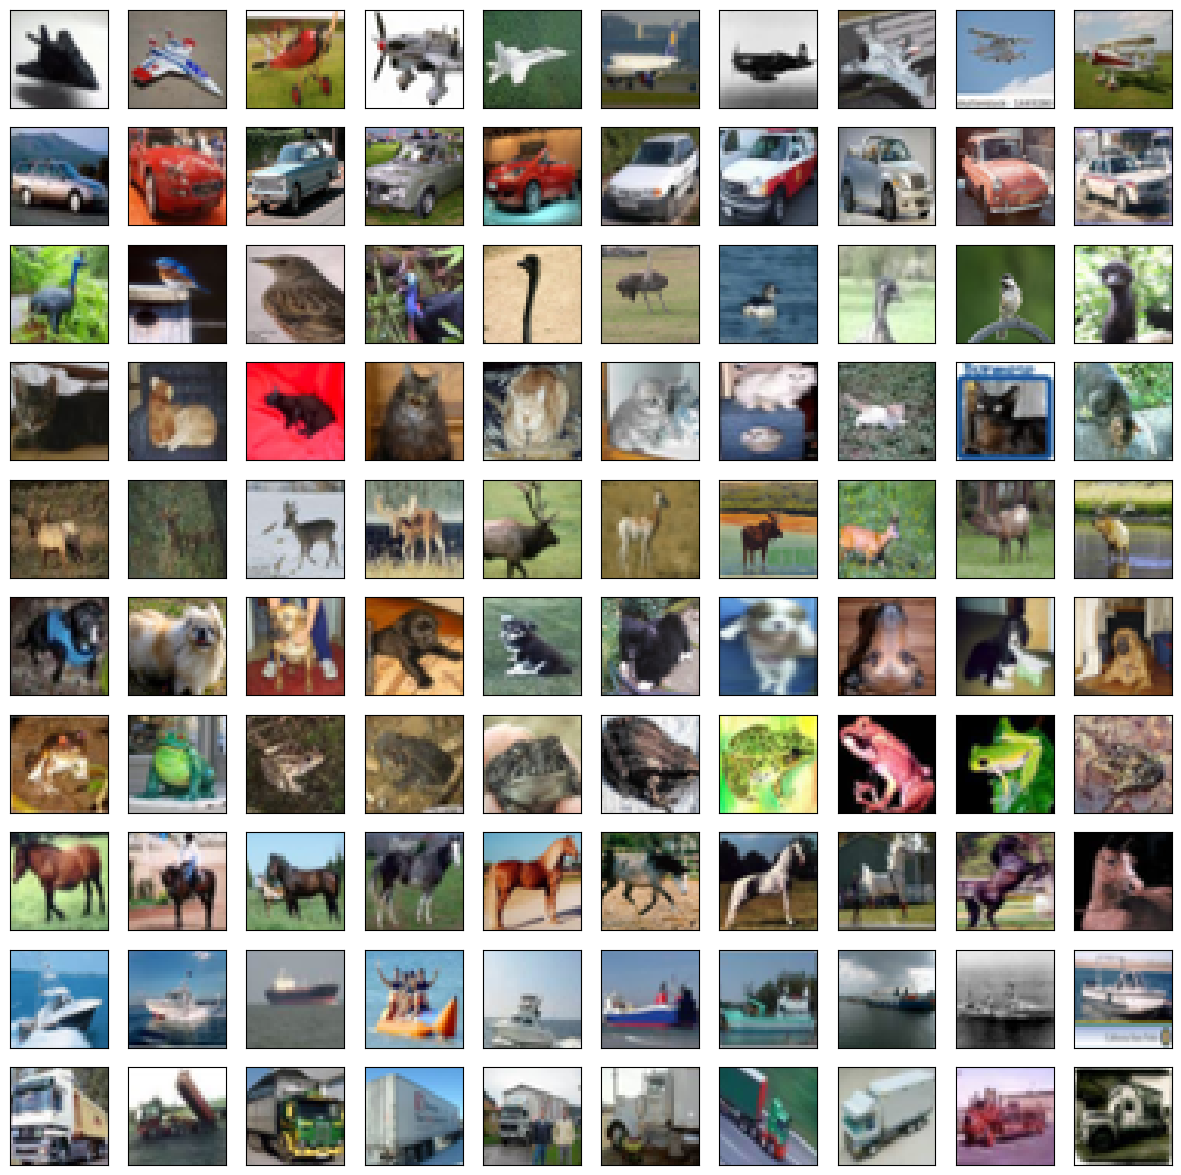

使用设备： cuda


Testing: 100%|██████████| 157/157 [00:01<00:00, 156.53it/s, Test Loss=0.7030, Test Acc=0.7573]

测试集损失：0.7030, 测试集准确率：0.7573


In [4]:
import os

#设置环境变量避免openmp报错
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

#引入torch的数据处理分析工具
import torchvision.transforms as transforms

#在线下载数据集
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

#下载数据集和测试集
data_path='.cifar10'
trainset=CIFAR10(root=data_path,train=True,download=True,transform=transforms.ToTensor())
testset=CIFAR10(root=data_path,train=False,download=True,transform=transforms.ToTensor())
print("测试集大小为：",len(testset))
print("训练集大小为：",len(trainset))

#可视化数据集
num_classes=10
fig,axes=plt.subplots(num_classes,10,figsize=(15,15))
#取出所有的类别
labels = np.array([t[1] for t in trainset])
for i in range(num_classes):
    #取出每个类别的前10张图片
    indices = np.where(labels == i)[0]
    for j in range(10):
        #显示图片的顺序为 宽 高 通道（C,H,W）
        axes[i, j].imshow(trainset[indices[j]][0].permute(1, 2, 0).numpy())
        #去除坐标刻度
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
plt.show()

#定义CNN神经网络
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.num_classes=num_classes
        #卷积层1
        #参数含义：输入通道数，输出通道数，卷积核大小，填充大小
        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        #卷积层2
        self.conv2=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1)
        #最大池化
        self.pooling1=nn.MaxPool2d(kernel_size=2)
        #随机暂退
        self.dropout1=nn.Dropout(p=0.25)
        #卷积层3
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        #卷积层4
        self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1)
        self.pooling2=nn.MaxPool2d(kernel_size=2)
        self.dropout2=nn.Dropout(p=0.25)
        
        #全连接层
        self.fc1=nn.Linear(in_features=64*8*8,out_features=512)
        self.dropout3=nn.Dropout(p=0.5)
        self.fc2=nn.Linear(in_features=512,out_features=self.num_classes)
        
    # forward函数定义了数据的前向传播过程
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=self.pooling1(x)
        x=self.dropout1(x)
        
        x=F.relu(self.conv3(x))
        x=F.relu(self.conv4(x))
        x=self.pooling2(x)
        x=self.dropout2(x)
        
        #把多维数据展平为一维
        x=x.view(x.size(0),-1)  # 修正：使用 x.size(0) 而不是 len(x)
        x=F.relu(self.fc1(x))
        x=self.dropout3(x)
        x=self.fc2(x)
        return x

#设置超参数 利用梯度下降优化
batch_size=64
learning_rate=1e-3
epochs=10  # 修正拼写错误
#设置随机数
np.random.seed(0)
torch.manual_seed(0)

#设置设备 使用GPU加速
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备：",device)

#批处理数据加载器
train_loader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(testset,batch_size=batch_size,shuffle=False)
model=CNN().to(device)  #将模型放置到设备上
#使用adam优化器
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
#使用交叉熵损失函数
criterion=nn.CrossEntropyLoss()

#开始训练
for epoch in range(epochs):  # 修正变量名
    total_loss=0
    total_correct=0
    total_samples=0
    #将模型设置为训练模式 dropout和batchnorm会在训练时起作用
    model.train()
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}') as pbar:
        for data in pbar:
            images,labels=data
            #放置到设备上
            images=images.to(device)
            labels=labels.to(device)
            #计算结果和损失
            outputs=model(images)
            loss_value=criterion(outputs,labels)
            #梯度优化
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            #累计统计
            batch_size_actual = labels.size(0)
            total_samples += batch_size_actual
            total_loss += loss_value.item() * batch_size_actual
            
            #计算准确率
            predicted = torch.argmax(outputs, dim=1)
            total_correct += (predicted == labels).sum().item()
            
            #更新进度条
            pbar.set_postfix({
                'Train Loss': f"{total_loss/total_samples:.4f}",
                'Train Acc': f"{total_correct/total_samples:.4f}",
            })

#测试模型在测试集上的表现
total_test_loss=0
total_test_correct=0
total_test_samples=0
#将模型设置为评估模式 dropout和batchnorm会在评估时起作用
model.eval()
with torch.no_grad():  # 添加 no_grad 以节省内存和加速
    with tqdm(test_loader, desc='Testing') as pbar:
        for data in pbar:
            images,labels=data
            #放置到设备上
            images=images.to(device)
            labels=labels.to(device)
            #计算结果和损失
            outputs=model(images)
            loss=criterion(outputs,labels)
            
            #累计统计
            batch_size_actual = labels.size(0)
            total_test_samples += batch_size_actual
            total_test_loss += loss.item() * batch_size_actual
            
            #计算准确率
            predicted = torch.argmax(outputs, dim=1)
            total_test_correct += (predicted == labels).sum().item()
            
            #更新进度条
            pbar.set_postfix({
                'Test Loss': f"{total_test_loss/total_test_samples:.4f}",
                'Test Acc': f"{total_test_correct/total_test_samples:.4f}",
            })
            
print(f"测试集损失：{total_test_loss/total_test_samples:.4f}, 测试集准确率：{total_test_correct/total_test_samples:.4f}")